# Note 3/16/2019

Accuracies based on various parameters

In this experiment, we are going to test the synthetic "MNIST" dataset, which is (very much) not linearly seperable. 

In [1]:
 
# import os
# import shutil
# if "README.md" in os.listdir():
#   print("The files are already in the folder")

    
# else:
#   !git clone https://github.com/wonjunee/mnist_gmu.git
#   for i in (os.listdir('./mnist_gmu')):
#     shutil.move("./mnist_gmu/{}".format(i), ".")

#   for i in (os.listdir('.')):
#     print(i)
  

In [2]:
from model_20190302 import *

import sys
import random
import pickle

random.seed(702)

/home/fred/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


------ HELPER   FUNCTIONS IMPORTED ------
------ TRAINING FUNCTIONS IMPORTED ------
------ TEST     FUNCTIONS IMPORTED ------
Function is ready


In [3]:
# import tensorflow as tf

# with tf.device('/device:gpu:0'):
#     a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#     b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#     c = tf.matmul(a, b)

# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
#     print (sess.run(c))
    
# print("GPU is being used!")

# Bringing the Dataset

In [4]:
from helper.generate_data_mnist import *

SIZE = 100
reduced = True
padding = True
# Generate the data
X_train, X_test, y_train, y_test, y_train_one_hot, y_test_one_hot = mnist_generate_data(reduced=reduced, train_size = SIZE, padding=padding)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Taking 100 per digit for train data
y train one hot encoding: (1000, 10)
y test one hot encoding: (10000, 10)

Training Set:   (1000, 32, 32, 1)
Test Set:       (10000, 32, 32, 1)
Done!


# Preprocessing

Shuffle the training data

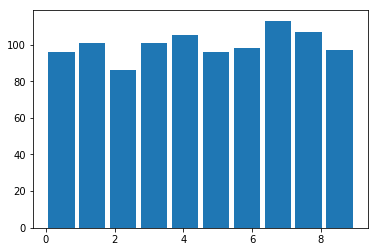

X_train: (1000, 32, 32, 1)
y_train: (1000, 1)


In [5]:
plt.hist(y_train, rwidth=0.85)
plt.show()

print("X_train:",X_train.shape)
print("y_train:",y_train.shape)

# Parameters

In [6]:
# learning rate
rate = 0.001

EPOCHS = 30
BATCH_SIZE = 128

# make sure to change this parameter!!!!!
filename = "without-batch-full-size-20190316"

# Training

In [ ]:
def evaluate(X_data, y_data):
    
    num_examples = len(X_data)
    sess = tf.get_default_session()
    
    accuracy = sess.run([accuracy_operation,correct_prediction,logits,fc4,fc6], feed_dict={x: X_data, y: y_data})
    
    return accuracy

In [ ]:
# Matrix sizes for svm training
mat_type_list = ["2", "4", "6"]

tf_only  = []
tf_svm2  = []
tf_svm4  = []
tf_svm6  = []
    
# initialize x axis for plot
epochs_ranges = []

accuracy_svc_linear = {}

for mat in mat_type_list:
    accuracy_svc_linear[mat] = []

x = tf.placeholder(tf.float32, (None, X_train.shape[1],X_train.shape[2],X_train.shape[3]), "x")
y = tf.placeholder(tf.int32, (None, 10), "y")

logits, fc4, fc6 = pipeline(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

accuracies = []

with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")

    for i in range(EPOCHS):
        output = sess.run([training_operation, logits, fc4, fc6], feed_dict={x: X_train, y: y_train_one_hot})

        if i % 2 == 0:

            print("\nEPOCHS:", i)
            Amat2,Amat4,Amat6 = output[1:]

            epochs_ranges.append(i)

            print("\nTesting...")
            test_accuracy,prediction_tf,Amat2_test,Amat4_test,Amat6_test = evaluate(X_test, y_test_one_hot)

            print("\nTest Accuracy = {:.3f}".format(test_accuracy))
            
            
            # Appending tensorflow accuracies to the tf_only
            tf_only.append(test_accuracy)

            '''

            in this model, there is no test data.
            it is only using train data and evaluate on the train data.
            so no need to worry about dividing into two sets

            in the next for loop, I used the term train and test but
            i just copied them from CIFAR10-tf-smaller.ipynb and didn't change the words.

            '''

            print("\nTesting with SVM")
            for train_mat_type in mat_type_list: # only 6 and 16

                if train_mat_type == "2":
                    train_matrix = Amat2.copy()
                    test_matrix  = Amat2_test.copy()
                elif train_mat_type == "4":
                    train_matrix = Amat4.copy()
                    test_matrix  = Amat4_test.copy()
                elif train_mat_type == "6":
                    train_matrix = Amat6.copy()
                    test_matrix  = Amat6_test.copy()                   

                # With linear kernel
                svc = SVC(kernel='linear')
                svc.fit(train_matrix, y_train)
                
                print("Y_train:",y_train.shape)
                print("Y_train:",y_test.shape)

                prediction = svc.predict(test_matrix)
                
                print("prediction:",prediction.shape)
                
                svc_linear_accuracy = np.sum(prediction==y_test.ravel())/len(prediction)

                print('\n train_mat_type: {}, Accuracy by SVC (linear): {}'.format(train_mat_type, svc_linear_accuracy))

                accuracy_svc_linear[train_mat_type].append(svc_linear_accuracy)

                # append accuracy to svm_only#
                if train_mat_type == "2":
                    tf_svm2.append(svc_linear_accuracy)
                elif train_mat_type == "4":
                    tf_svm4.append(svc_linear_accuracy)
                elif train_mat_type == "6":
                    tf_svm6.append(svc_linear_accuracy)

    for train_mat_type in mat_type_list:
        plt.figure(figsize=(10,5))
        plt.plot(epochs_ranges, accuracy_tf, 'o', label="TF")
        plt.plot(epochs_ranges, accuracy_svc_linear[train_mat_type], 'o',label="SVC (linear)")

        a = np.argmax(accuracy_tf)
        plt.annotate(accuracy_tf[a], (epochs_ranges[a], accuracy_tf[a]))

        a = np.argmax(accuracy_svc_linear[train_mat_type])
        plt.annotate(accuracy_svc_linear[train_mat_type][a], (epochs_ranges[a], accuracy_svc_linear[train_mat_type][a]))

        plt.legend()
        title  = "MNIST TF vs. SVC (linear) matrix size {}.png".format(train_mat_type)
        title1 = title
        

        plt.title(title1)
        plt.grid()
        plt.savefig(title)

        plt.show()

pickle.dump({"tf_only":tf_only, "tf_svm2":tf_svm2, "tf_svm4":tf_svm4, "tf_svm6":tf_svm6}, open("{}.p".format(filename)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Training...
